cuda:0


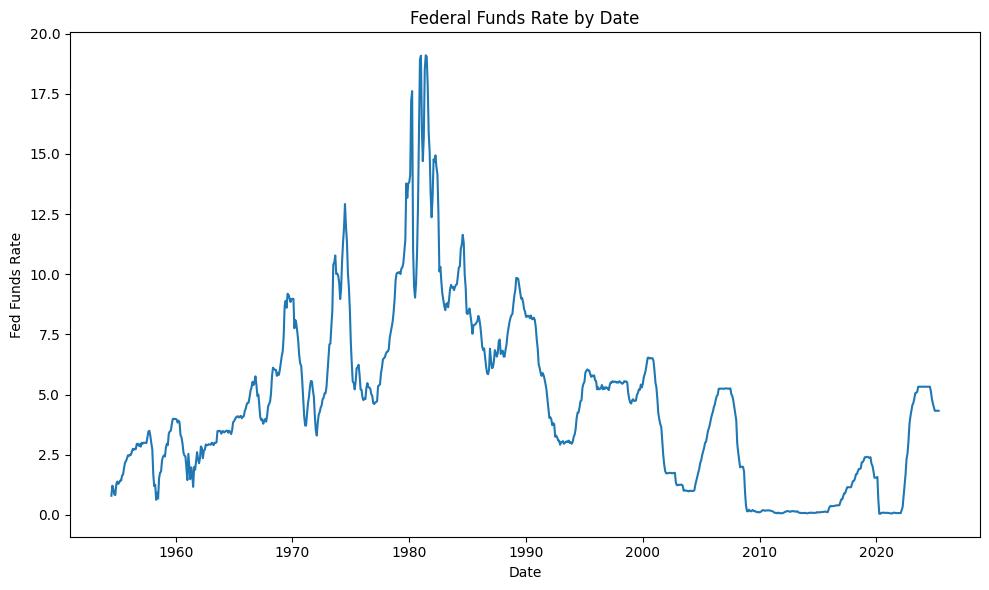

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.api import adfuller,seasonal_decompose



fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)
data.head(10)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Federal Funds Rate by Date")
plt.savefig("images/federal-funds-rate-date.png")
plt.tight_layout()
plt.show()





C:\Users\katsa\AppData\Local\Temp\ipykernel_6268\931405408.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
C:\Users\katsa\AppData\Local\Temp\ipykernel_6268\931405408.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decom.plot().show()


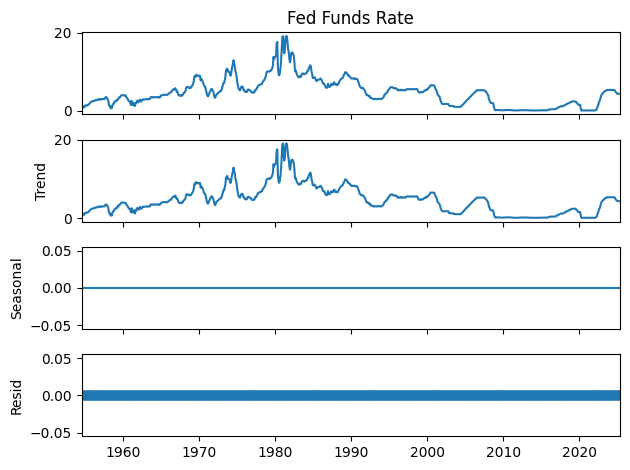

In [2]:
"""df for Timeseries without torch"""

df = data.copy()

df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)

df_index = df.set_index('Date')

decom = seasonal_decompose(df_index['Fed Funds Rate'],period=1)
decom.plot().show()

In [3]:
"""Adfueller Test"""

def test_stationary(timeseries):
    rollingmean = timeseries.rolling(window=12).mean()
    rollingstd = timeseries.rolling(window=12).std()
    plt.figure(figsize=(12,6))
    plt.plot(timeseries,color='red',label="Actual")
    plt.plot(rollingmean,color="blue",label="Rolling Mean")
    plt.plot(rollingstd,color="green",label="Rolling Standard Deviation")
    plt.title("Rolling Mean And Standard Deviation")
    plt.legend(loc="best")
    plt.show(block=False)
    
    print('Dickey Fueller Test\n')
    dftest = adfuller(df_index['Fed Funds Rate'],autolag="AIC")
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


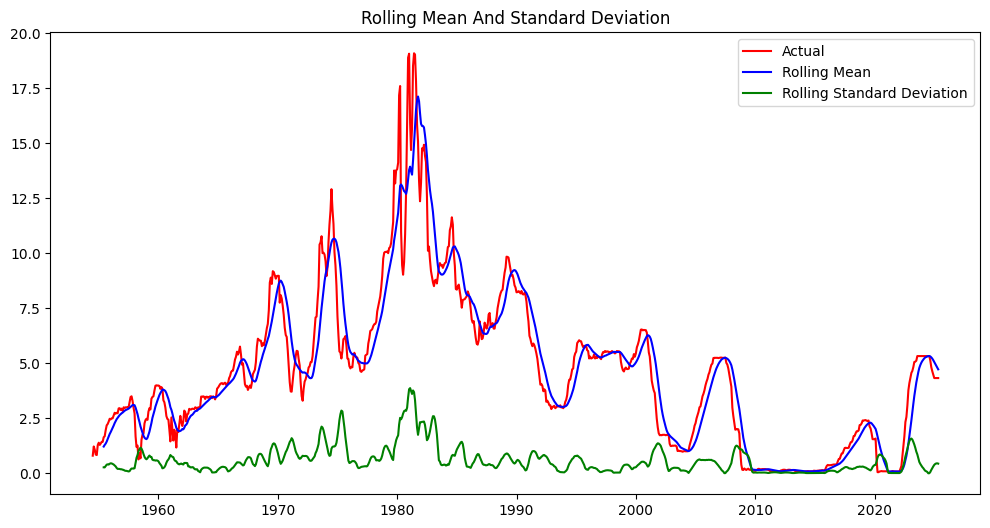

Dickey Fueller Test

Test Statistic           -2.980492
p-value                   0.036757
Lags Used                17.000000
No. of Obs              833.000000
Critical Value (1%)      -3.438225
Critical Value (5%)      -2.865016
Critical Value (10%)     -2.568621
dtype: float64


In [4]:
"""Testing stationary with no lags"""



test_stationary(df_index)

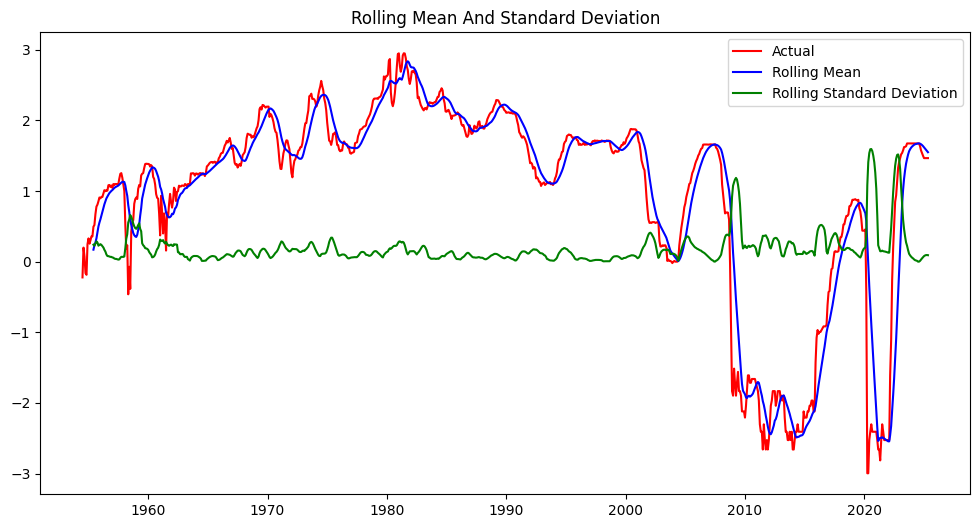

Dickey Fueller Test

Test Statistic           -2.980492
p-value                   0.036757
Lags Used                17.000000
No. of Obs              833.000000
Critical Value (1%)      -3.438225
Critical Value (5%)      -2.865016
Critical Value (10%)     -2.568621
dtype: float64


In [5]:


df_log = np.log(df_index)

df_log = df_log.dropna()


test_stationary(df_log)

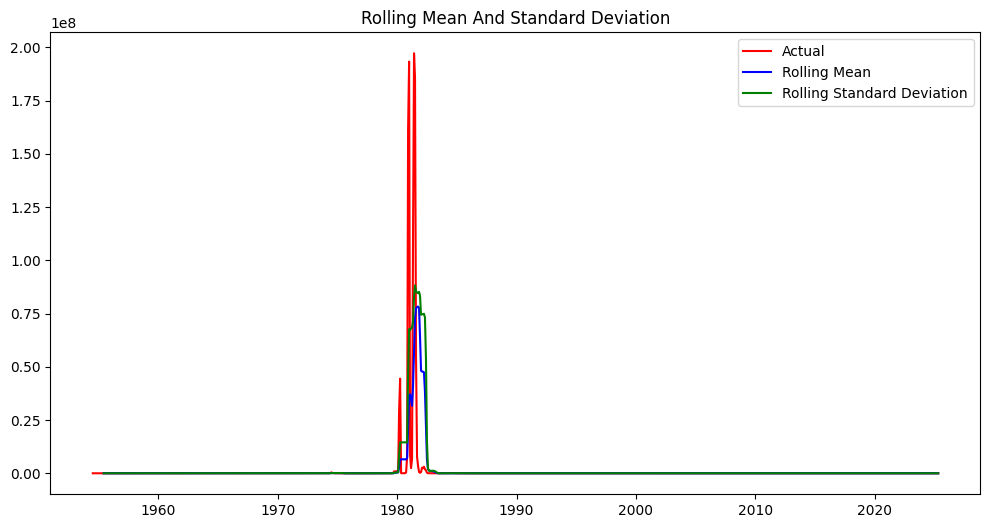

Dickey Fueller Test

Test Statistic         -5.886544e+00
p-value                 2.992306e-07
Lags Used               2.100000e+01
No. of Obs              8.290000e+02
Critical Value (1%)    -3.438263e+00
Critical Value (5%)    -2.865033e+00
Critical Value (10%)   -2.568630e+00
dtype: float64


In [6]:
df_index = np.exp(df_index)
df_index.dropna(inplace=True)
test_stationary(df_index)

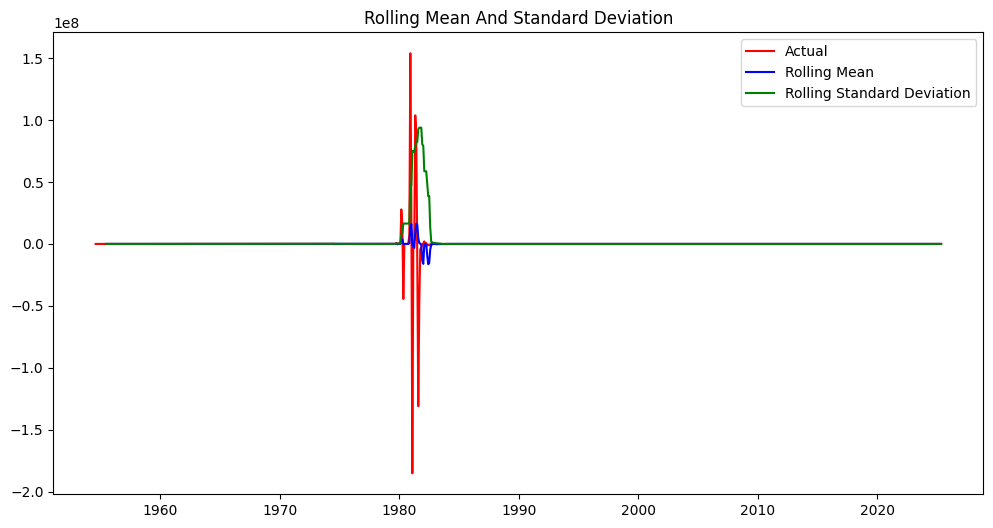

Dickey Fueller Test

Test Statistic         -5.886544e+00
p-value                 2.992306e-07
Lags Used               2.100000e+01
No. of Obs              8.290000e+02
Critical Value (1%)    -3.438263e+00
Critical Value (5%)    -2.865033e+00
Critical Value (10%)   -2.568630e+00
dtype: float64


In [7]:
"""1st order diff"""

df_diff = df_index.diff(1)

df_diff = df_diff.dropna()

test_stationary(df_diff)






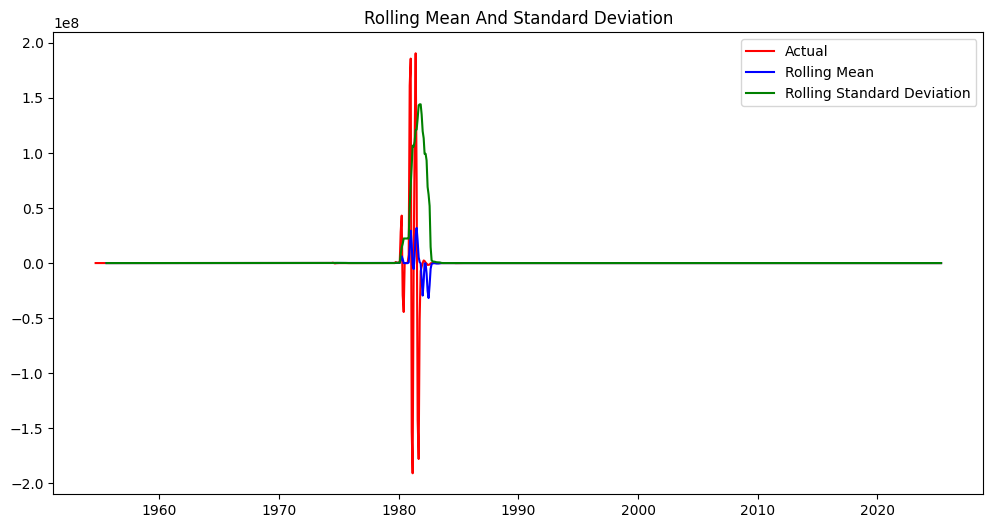

Dickey Fueller Test

Test Statistic         -5.886544e+00
p-value                 2.992306e-07
Lags Used               2.100000e+01
No. of Obs              8.290000e+02
Critical Value (1%)    -3.438263e+00
Critical Value (5%)    -2.865033e+00
Critical Value (10%)   -2.568630e+00
dtype: float64


In [8]:
"""Second Order diff"""

df_diff2 = df_index.diff(2)
df_diff2 = df_diff2.dropna()

test_stationary(df_diff2)






In [9]:
data = data.shift(1)
data.dropna(inplace=True)
training = data.iloc[:,0:1].values



train_split = int(len(training) * .88)
train_data = training[:train_split]
test_data = training[train_split:]
print(train_data.shape)
print(test_data.shape)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length - 1):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1
X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()





class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=64,num_layers=2,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

(748, 1)
(102, 1)


C:\Users\katsa\AppData\Local\Temp\ipykernel_6268\497571003.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_6268\497571003.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2616; Test RSME: 0.1069
Epoch: 1; train_RSEM: 0.2573; Test RSME: 0.1049
Epoch: 2; train_RSEM: 0.2532; Test RSME: 0.1032
Epoch: 3; train_RSEM: 0.2491; Test RSME: 0.1019
Epoch: 4; train_RSEM: 0.2451; Test RSME: 0.1009
Epoch: 5; train_RSEM: 0.2412; Test RSME: 0.1003
Epoch: 6; train_RSEM: 0.2373; Test RSME: 0.1001
Epoch: 7; train_RSEM: 0.2335; Test RSME: 0.1002
Epoch: 8; train_RSEM: 0.2297; Test RSME: 0.1007
Epoch: 9; train_RSEM: 0.2261; Test RSME: 0.1017
Epoch: 10; train_RSEM: 0.2225; Test RSME: 0.103
Epoch: 11; train_RSEM: 0.219; Test RSME: 0.1047
Epoch: 12; train_RSEM: 0.2156; Test RSME: 0.1068
Epoch: 13; train_RSEM: 0.2123; Test RSME: 0.1093
Epoch: 14; train_RSEM: 0.2091; Test RSME: 0.1121
Epoch: 15; train_RSEM: 0.2061; Test RSME: 0.1153
Epoch: 16; train_RSEM: 0.2032; Test RSME: 0.1188
Epoch: 17; train_RSEM: 0.2005; Test RSME: 0.1226
Epoch: 18; train_RSEM: 0.1979; Test RSME: 0.1267
Epoch: 19; train_RSEM: 0.1955; Test RSME: 0.1311
Epoch: 20; train_RSEM: 0.1934; T

In [10]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length: -1]['Date'].reset_index(drop=True)


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Interest Rate": actual_rescaled.flatten(),
    "Predicted Interest Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Interest Rate  Predicted Interest Rate
0  2016-12-01                  0.54                 0.445663
1  2017-01-01                  0.65                 0.572765
2  2017-02-01                  0.66                 0.680426
3  2017-03-01                  0.79                 0.690219
4  2017-04-01                  0.90                 0.817600
5  2017-05-01                  0.91                 0.925493
6  2017-06-01                  1.04                 0.935306
7  2017-07-01                  1.15                 1.062954
8  2017-08-01                  1.16                 1.171068
9  2017-09-01                  1.15                 1.180902
10 2017-10-01                  1.15                 1.171068
11 2017-11-01                  1.16                 1.171068
12 2017-12-01                  1.30                 1.180902
13 2018-01-01                  1.41                 1.318648
14 2018-02-01                  1.42                 1.426982
15 2018-03-01           

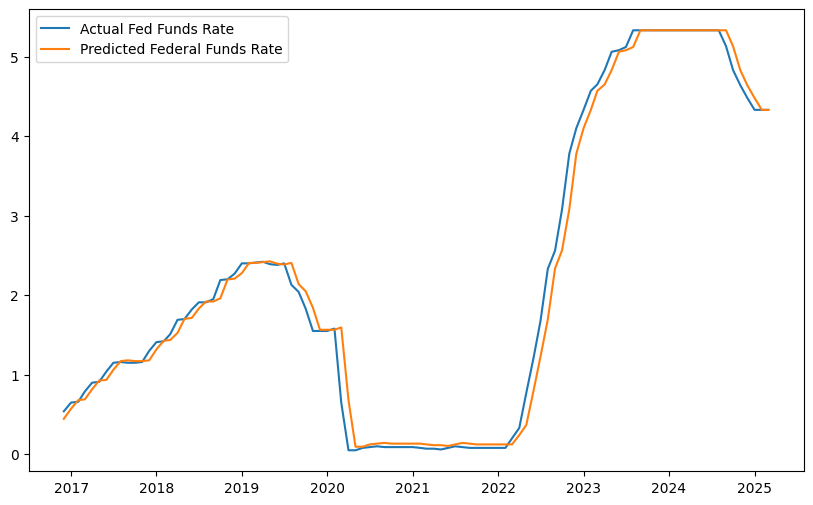

In [11]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Interest Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Interest Rate'],label="Predicted Federal Funds Rate")
plt.legend()
plt.savefig("images/predicted-vs-actual.png")
plt.show()